In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
!unzip -uq "/content/ResizeDataset.zip" -d "/content"

unzip:  cannot find or open /content/ResizeDataset.zip, /content/ResizeDataset.zip.zip or /content/ResizeDataset.zip.ZIP.


In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import os
import numpy as np
from keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers


In [ ]:
train_dir=r'/content/drive/MyDrive/Colab Notebooks/Dataset/train'

In [ ]:
Labels = ['Benign', 'Malignant']

In [ ]:
print ("class : ") 
for i in range(len(Labels)): 
    print (i, end = " ") 
    print (Labels[i]) 

class : 
0 Benign
1 Malignant


In [ ]:
print('Number of classes:',len(Labels))

Number of classes: 2


In [ ]:
module_selection = ("mobilenet_v2", 224, 1280) 
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/2".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
BATCH_SIZE = 16 

In [ ]:
IMAGE_SIZE

(224, 224)

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest',
      validation_split=0.4)
  
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

validation_generator = train_datagen.flow_from_directory(
    train_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    subset="validation",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

Found 1598 images belonging to 2 classes.
Found 1065 images belonging to 2 classes.


In [ ]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,input_shape=IMAGE_SIZE+(3,), output_shape=[FV_SIZE]  )


In [ ]:
do_fine_tuning = False 
if do_fine_tuning:
  feature_extractor.trainable = True
  for layer in base_model.layers[-30:]:
    layer.trainable =True
  
else:
  feature_extractor.trainable = False

In [ ]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
#model.build((None,)+IMAGE_SIZE+(3,))

model.summary()

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 2,914,882
Trainable params: 656,898
Non-trainable params: 2,257,984
___________________

In [ ]:
LEARNING_RATE = 0.001 
model.compile(
   optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])

In [ ]:
EPOCHS=15
history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size)

Epoch 1/15
99/99 [==============================] - 479s 5s/step - loss: 0.5096 - accuracy: 0.8053 - val_loss: 0.7348 - val_accuracy: 0.6752
Epoch 2/15
99/99 [==============================] - 36s 364ms/step - loss: 0.3355 - accuracy: 0.8515 - val_loss: 0.6143 - val_accuracy: 0.7415
Epoch 3/15
99/99 [==============================] - 36s 365ms/step - loss: 0.3144 - accuracy: 0.8635 - val_loss: 0.4814 - val_accuracy: 0.7907
Epoch 4/15
99/99 [==============================] - 37s 376ms/step - loss: 0.2866 - accuracy: 0.8767 - val_loss: 0.4594 - val_accuracy: 0.8144
Epoch 5/15
99/99 [==============================] - 36s 362ms/step - loss: 0.2629 - accuracy: 0.8919 - val_loss: 0.5112 - val_accuracy: 0.7831
Epoch 6/15
99/99 [==============================] - 36s 368ms/step - loss: 0.2567 - accuracy: 0.8944 - val_loss: 0.5708 - val_accuracy: 0.7784
Epoch 7/15
99/99 [==============================] - 36s 364ms/step - loss: 0.2469 - accuracy: 0.8951 - val_loss: 0.5253 - val_accuracy: 0.7699
E

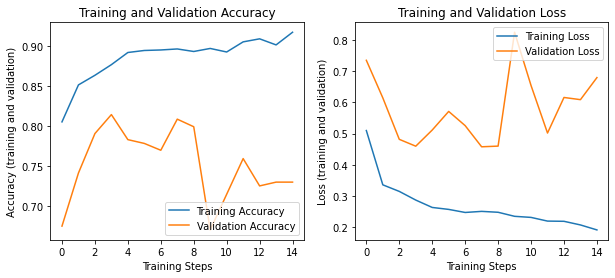

In [ ]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

class: Benign, confidence: 0.532017


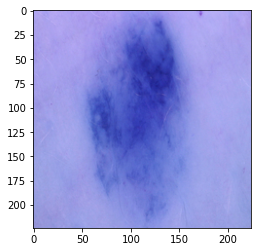

<Figure size 432x288 with 0 Axes>

class: Malignant, confidence: 0.682805


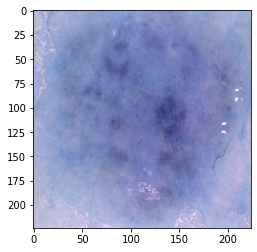

class: Malignant, confidence: 0.964657


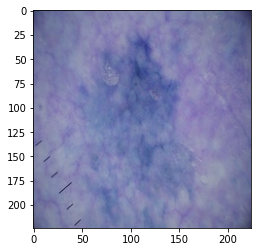

<Figure size 432x288 with 0 Axes>

class: Benign, confidence: 0.954156


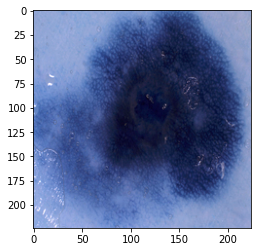

<Figure size 432x288 with 0 Axes>

class: Benign, confidence: 0.650291


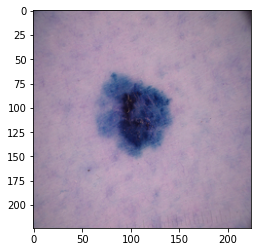

<Figure size 432x288 with 0 Axes>

class: Malignant, confidence: 0.715796


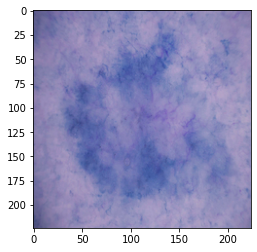

<Figure size 432x288 with 0 Axes>

class: Malignant, confidence: 0.984421


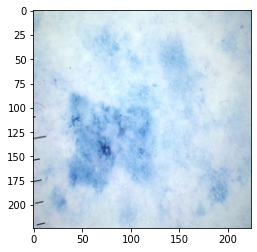

<Figure size 432x288 with 0 Axes>

class: Benign, confidence: 0.630068


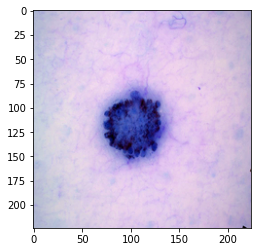

<Figure size 432x288 with 0 Axes>

class: Benign, confidence: 0.730995


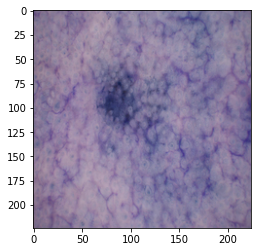

<Figure size 432x288 with 0 Axes>

class: Malignant, confidence: 0.775109


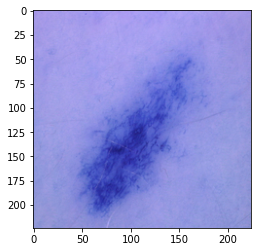

<Figure size 432x288 with 0 Axes>

class: Benign, confidence: 0.936492


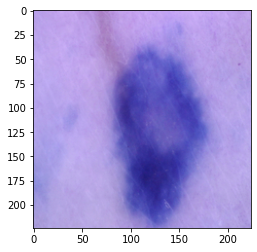

<Figure size 432x288 with 0 Axes>

class: Benign, confidence: 0.758630


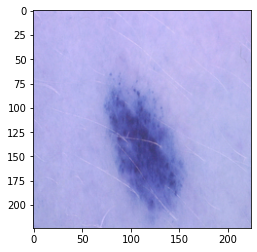

<Figure size 432x288 with 0 Axes>

class: Benign, confidence: 0.828053


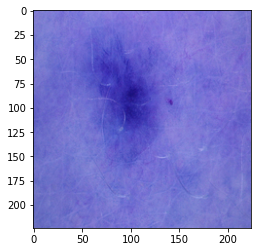

<Figure size 432x288 with 0 Axes>

class: Malignant, confidence: 0.918613


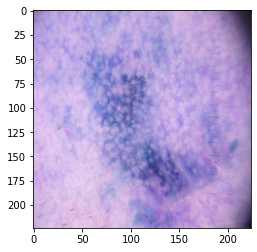

<Figure size 432x288 with 0 Axes>

class: Benign, confidence: 0.879569


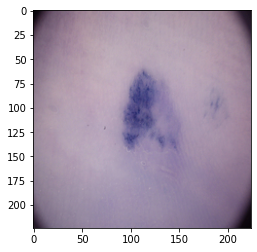

<Figure size 432x288 with 0 Axes>

class: Malignant, confidence: 0.595739


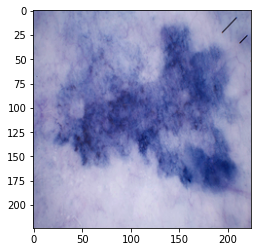

<Figure size 432x288 with 0 Axes>

In [ ]:
import random
import cv2
def upload(filename):
    img = cv2.imread(os.path.join(train_dir, filename))
    img = cv2.resize(img, (224, 224) )
    img = img /255
    
    return img

def pre_result(image):
    x = model.predict(np.asarray([img]))[0]
    classx = np.argmax(x)
    
    return {Labels[classx]: x[classx]}

images = random.sample(validation_generator.filenames, 16)

for idx, filename in enumerate(images):
    
    
    img = upload(filename)
    prediction = pre_result(img)
    print("class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
predictions1 = model.predict(validation_generator, steps=len(validation_generator))
y = np.argmax(predictions1, axis=1)

print('Classification Report')
cr = classification_report(y_true=validation_generator.classes, y_pred=y, target_names=validation_generator.class_indices)
print(cr)

evaluates = model.evaluate(validation_generator)

print(evaluates)

Classification Report
              precision    recall  f1-score   support

      benign       0.67      0.97      0.80       576
   malignant       0.92      0.45      0.61       489

    accuracy                           0.73      1065
   macro avg       0.80      0.71      0.70      1065
weighted avg       0.79      0.73      0.71      1065

67/67 [==============================] - 15s 217ms/step - loss: 0.6683 - accuracy: 0.7249
[0.6683365106582642, 0.7248826026916504]


Confusion Matrix


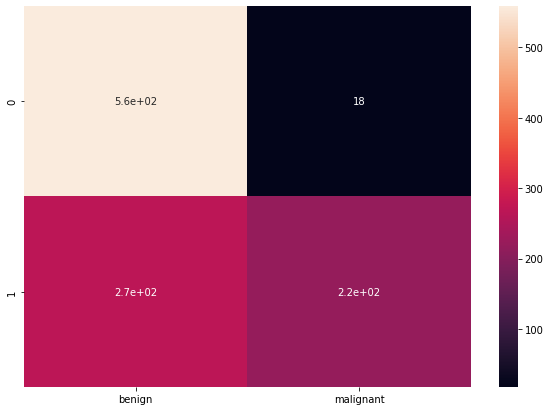

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sn
print('Confusion Matrix')
cm = confusion_matrix(validation_generator.classes, y)
df = pd.DataFrame(cm, columns=validation_generator.class_indices)
plt.figure(figsize=(10,7))
sn.heatmap(df, annot=True)

In [ ]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
import numpy as np

#path of the directory where you want to save your model
frozen_out_path = ''
# name of the .pb file
frozen_graph_filename = "frozen_graph"

# Convert Keras model to ConcreteFunction
full_model = tf.function(lambda x: model(x))
full_model = full_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))

# Get frozen graph def
frozen_func = convert_variables_to_constants_v2(full_model)
frozen_func.graph.as_graph_def()

layers = [op.name for op in frozen_func.graph.get_operations()]
print("-" * 60)
print("Frozen model layers: ")
for layer in layers:
    print(layer)
print("-" * 60)
print("Frozen model inputs: ")
print(frozen_func.inputs)
print("Frozen model outputs: ")
print(frozen_func.outputs)

tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir=frozen_out_path,
                  name=f"{frozen_graph_filename}.pb",
                  as_text=False)
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir=frozen_out_path,
                  name=f"{frozen_graph_filename}.pbtxt",
                  as_text=True)

------------------------------------------------------------
Frozen model layers: 
x
sequential/keras_layer/87154
Func/sequential/keras_layer/StatefulPartitionedCall/input/_1
sequential/keras_layer/87172
Func/sequential/keras_layer/StatefulPartitionedCall/input/_10
sequential/keras_layer/87362
Func/sequential/keras_layer/StatefulPartitionedCall/input/_105
sequential/keras_layer/87356
Func/sequential/keras_layer/StatefulPartitionedCall/input/_102
sequential/keras_layer/87364
Func/sequential/keras_layer/StatefulPartitionedCall/input/_106
sequential/keras_layer/87376
Func/sequential/keras_layer/StatefulPartitionedCall/input/_112
sequential/keras_layer/87358
Func/sequential/keras_layer/StatefulPartitionedCall/input/_103
sequential/keras_layer/87374
Func/sequential/keras_layer/StatefulPartitionedCall/input/_111
sequential/keras_layer/87378
Func/sequential/keras_layer/StatefulPartitionedCall/input/_113
sequential/keras_layer/87176
Func/sequential/keras_layer/StatefulPartitionedCall/input/_12

'frozen_graph.pbtxt'

In [ ]:
!zip -r /content/file.zip /</content/frozen_graph.pbtxt>

/bin/bash: -c: line 0: syntax error near unexpected token `newline'
/bin/bash: -c: line 0: `zip -r /content/file.zip /</content/frozen_graph.pbtxt>'


In [ ]:
from google.colab import files
files.download("/content/frozen_graph.pbtxt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>